# Training Deep Neural Networks on a GPU with PyTorch

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figure
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

We can download the data and create a PyTorch dataset using the MNIST class from torchvision.datasets.

In [2]:
dataset = MNIST(root='data/', download = True, transform = ToTensor())

Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape 1x28x28 (the dimensions represent color channels, width and height). We can use plt.imshow to display the images. However, plt.imshow expects channels to be last dimension in an image tensor, so we use the permute method to reorder the dimensions of the image.

image.shape: torch.Size([1, 28, 28])
Label: 5


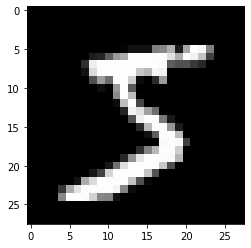

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
print('Label:', label)

Next, let's use the random_split helper function to set aside 10000 images for our validation set.

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [5]:
batch_size = 128

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle = True, \
                         num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers = 4, \
                        pin_memory = True)

Can you figure out the purpose of the arguments num_workers and pin_memory? Try looking into the documentation: https://pytorch.org/docs/stable/data.html .

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

images.shape: torch.Size([128, 1, 28, 28])


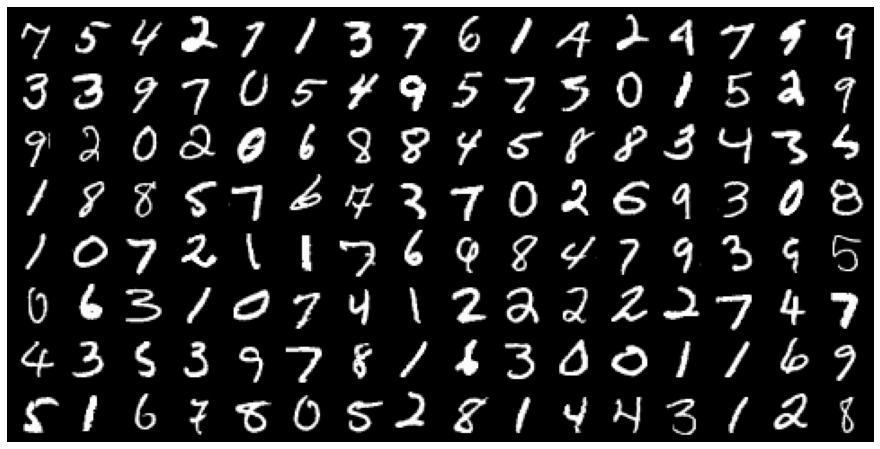

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize = (16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow = 16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a hidden layer and an output layer. Additionally, we'll use an activation function between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the 1x28x28 images into vectors of size 784, so they can be passed into an nn.Linear object.

In [8]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a nn.Linear object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the learning capacity of the model.

In [9]:
input_size = inputs.shape[-1]
hidden_size = 32

In [10]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing inputs through layer1.

In [11]:
inputs.shape

torch.Size([128, 784])

In [12]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size 784 are transformed into intermediate output vectors of length 32 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias. We can verify this using torch.allclose. For a more detailed explanation, review the tutorial on linear regression.

In [13]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [14]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, layer1_outputs and inputs have a linear relationship, i.e., each element of layer_outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs.

![w_and_b](https://i.imgur.com/inXsLuq.png)

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

![relu](https://i.imgur.com/yijV4xF.png)

We can use the F.relu method to apply ReLU to the elements to a tensor

torch.allclose(input, other, rtol=1e-05, atol=1e-08, equal_nan=False) → bool
This function checks if all input and other satisfy the condition:

\lvert \text{input} - \text{other} \rvert \leq \texttt{atol} + \texttt{rtol} \times \lvert \text{other} \rvert
∣input−other∣≤atol+rtol×∣other∣
elementwise, for all elements of input and other. The behaviour of this function is analogous to numpy.allclose

In [15]:
F.relu(torch.tensor([[1, -1, 0],
                    [-0.1, 0.2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to layer1_outputs and verify that negative values were replaced with 0.



In [16]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6968787312507629
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, relu_outputs and inputs do not have a linear relationship. We refer to ReLU as the activation function, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length hidden_size in relu_outputs into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [17]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [18]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [19]:
inputs.shape

torch.Size([128, 784])

As expected, layer2_outputs contains a batch of vectors of size 10. We can now use this output to compute the loss using F.cross_entropy and adjust the weights of layer1 and layer2 using gradient descent.

In [27]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3155, grad_fn=<NllLossBackward>)

Thus, our model transforms inputs into layer2_outputs by applying a linear transformation (using layer1), followed by a non-linear activation (using F.relu), followed by another linear transformation (using layer2). Let's verify this by re-computing the output using basic matrix operations.

In [28]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [29]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Note that outputs and inputs do not have a linear relationship due to the non-linear activation function F.relu. As we train the model and adjust the weights of layer1 and layer2, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since hidden_size does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A deep neural network is simply a neural network with one or more hidden layers. In fact, the Universal Approximation Theorem states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can learn rich and complex non-linear relationships between inputs and targets. Here are some examples:

 - Identifying if an image contains a cat or a dog (or something else)
 - Identifying the genre of a song using a 10-second sample
 - Classifying movie reviews as positive or negative based on their content
 - Navigating self-driving cars using a video feed of the road
 - Translating sentences from English to French (and hundreds of other languages)
 - Converting a speech recording to text and vice versa
 - And many more...
 
It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [23]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [24]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [25]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [26]:
torch.allclose(outputs2, outputs3, 1e-3)

True

https://pytorch.org/docs/stable/generated/torch.allclose.html

## Model


We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

 - Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.

 - The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size. The parameter hidden_size can be configured manually (e.g., 32 or 64).

 - We'll then apply a non-linear activation function to the intermediate outputs. The activation function transforms individual elements of the matrix.

 - The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size batch_size x 10. We can use this output to compute the loss and adjust weights using gradient descent.

As discussed above, our model will contain one hidden layer. Here's what it looks like visually:


In [35]:
class MnistModel(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size):
        
        super().__init__()
        # Hidden Layer
        self.linear1 = nn.Linear(input_size, hidden_size)
        # Output Layer
        self.linear2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, xb):
        
        xb = xb.reshape(-1, input_size)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an accuracy function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in validation_step above.

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
input_size = 784
hidden_size = 32
num_classes = 10

In [36]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [37]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [38]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3028671741485596
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2760,  0.0282, -0.1484, -0.0844,  0.0483, -0.0679, -0.2252,  0.3094,
          0.1759,  0.0663],
        [ 0.1761,  0.1235, -0.1521,  0.0004,  0.2388, -0.0997, -0.1871,  0.2409,
          0.1434,  0.0414]])


## Training the Model

We'll define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the previous tutorial.

In [39]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device.